In [1]:
import os
os.chdir('../src/')

In [2]:
from importlib import reload
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn import decomposition, model_selection, svm, linear_model
import math
from finta import TA
import statsmodels

In [3]:
df = pd.read_json('../data/raw/BTC_ETH.json')
df.tail()

close                date      high       low      open  \
59209  0.032398 2018-12-23 17:30:00  0.032440  0.032264  0.032279   
59210  0.032335 2018-12-23 18:00:00  0.032388  0.032264  0.032384   
59211  0.032439 2018-12-23 18:30:00  0.032456  0.032341  0.032373   
59212  0.032444 2018-12-23 19:00:00  0.032473  0.032398  0.032403   
59213  0.032380 2018-12-23 19:30:00  0.032444  0.032356  0.032444   

       quoteVolume    volume  weightedAverage  
59209   167.521008  5.415495         0.032327  
59210    59.336265  1.919648         0.032352  
59211   188.175282  6.101123         0.032423  
59212   157.947252  5.122461         0.032431  
59213    60.197846  1.950349         0.032399

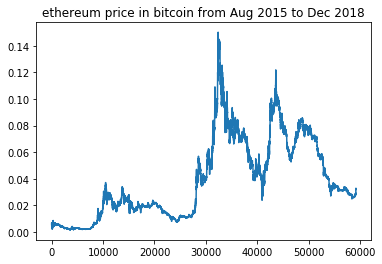

In [4]:
df.close.plot(title='ethereum price in bitcoin from Aug 2015 to Dec 2018')

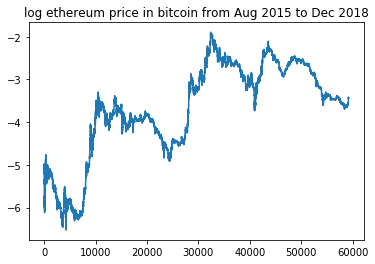

In [5]:
pd.Series(np.log(df.close)).plot(title='log ethereum price in bitcoin from Aug 2015 to Dec 2018')

Log prices actually look more well behaved. Constant growth rate should be a straight line in the price graph, which in log prices it actually is, as opposed to something stupid in non-log prices.

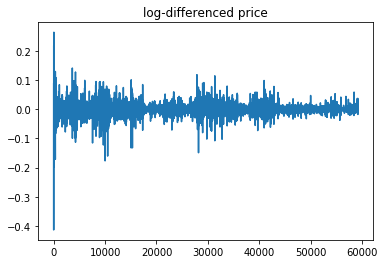

In [21]:
df['log_diff'] = pd.Series(np.log(df.close)).diff()
df.log_diff.plot(title='log-differenced price')

The first few price differences do have an abnormally high norm, let's remove them.

In [22]:
df = df[2000:]

In [7]:
df.isnull().sum()

close              0
date               0
high               0
low                0
open               0
quoteVolume        0
volume             0
weightedAverage    0
dtype: int64

Hurray! We have no nulls!

In [8]:
print(len(df))
df.head()

59214


close                date      high       low       open   quoteVolume  \
0  0.005501 2015-08-08 05:00:00  50.00000  0.005501  50.000000   4333.469000   
1  0.006000 2015-08-08 05:30:00   0.01280  0.005500   0.005501   3642.226628   
2  0.005875 2015-08-08 06:00:00   0.00719  0.005000   0.006900  14607.375725   
3  0.006500 2015-08-08 06:30:00   0.00659  0.005223   0.005425  12520.280800   
4  0.006890 2015-08-08 07:00:00   0.00690  0.005873   0.006340   6799.871349   

      volume  weightedAverage  
0  33.932021         0.007830  
1  21.749825         0.005972  
2  84.009002         0.005751  
3  74.269166         0.005932  
4  44.791872         0.006587

## What do all these features mean?

I am guessing that *volume* is given in *bitcoin* and quoted volume is the corresponding amount in *ethereum*.

In [23]:
pd.concat([df.volume / df.weightedAverage, df.quoteVolume], axis=1).head()

0   quoteVolume
2000  14640.678555  14640.673648
2001  28759.370117  28759.357018
2002   3481.788564   3481.783586
2003   2889.778120   2889.771728
2004   1637.671817   1637.668127

It seems they compute the *quoteVolume* with the *weightedAverage*(otherwise the values don't match), but what is the *weighted average*? [This](https://www.reddit.com/r/ethereumnoobies/comments/86zv9s/weighted_average_eth_usd_poloniex/dwa4gtc) reddit user suggests that it is the price weighted by trade volume, which sounds like a very reasonable measure to have.

## Autocorrelation

The following plots show that there is actual autocorrelation going on(though barely), but more importantly, variance of the series is *very* autocorrelated, maybe the variance will be less autocorrelated once we look at the residuals of a fit. For fun I also plotted the skew autocorrelation and higher order moments.

In [10]:
df['logarithmic_returns'] = pd.Series(np.log(df.close)).diff()

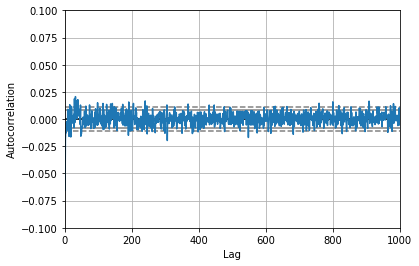

In [33]:
ax = plt.gca(xlim=(1, 1000), ylim=(-0.1, 0.1))
autocorrelation_plot(df.log_diff, ax=ax)

Variance autocorrelation:

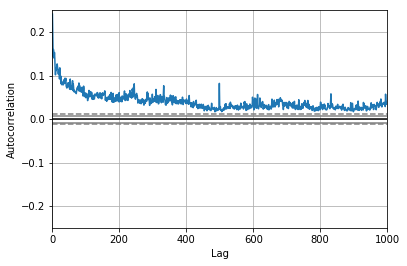

In [30]:
ax = plt.gca(xlim=(1, 1000), ylim=(-0.25, 0.25))
autocorrelation_plot(np.square(df.log_diff), ax=ax)

Skew autocorrelation:

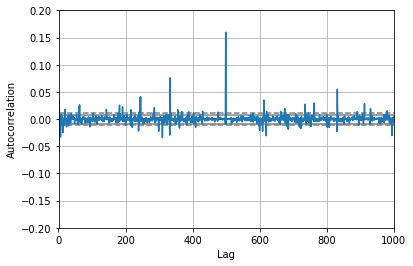

In [31]:
ax = plt.gca(xlim=(1, 1000), ylim=(-0.2, 0.2))
autocorrelation_plot(np.power(df.log_diff, np.full(len(df), 3)), ax=ax)

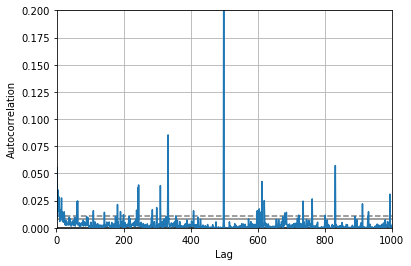

In [35]:
ax = plt.gca(xlim=(1, 1000), ylim=(0, 0.2))
autocorrelation_plot(np.power(df.log_diff, np.full(len(df), 4)), ax=ax)

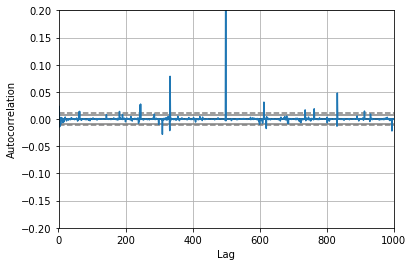

In [37]:
ax = plt.gca(xlim=(1, 1000), ylim=(-0.2, 0.2))
autocorrelation_plot(np.power(df.log_diff, np.full(len(df), 5)), ax=ax)

There is a **huge** spike at 500, how much time is that? Apparently 10 days.

In [39]:
500 * 30 / 60 / 24

10.416666666666666

12h correlation is **much** higher.

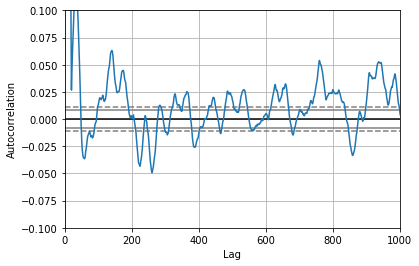

In [19]:
ax = plt.gca(xlim=(1, 1000), ylim=(-0.1, 0.1))
autocorrelation_plot(pd.Series(np.log(df.close)).diff(20)[2000:], ax=ax)

This ilustrates volatility clustering is a very real thing.

## Convolution stuff

Let a convolution $p * f$ of the time series $p$ by $f = [a_0, a_2, ... ,a_{n-1}]$ be defined by $(p * f)(t) = \sum_{i=0}^{n-1}{p_{t-i}f_{i}}$.

Convolutions are used suprisingly often in technical indicators. Examples are:
* lag $[0,1,...,0]$
* difference $[0,-1,...,0,0,0]$
* moving average $ma(n) = 1/n[1,..,1]$, where the 1 is repeated n times
* exponential moving averages: $ema(n) = [1-\alpha,...,(1-\alpha)\alpha^n]$
* moving average convergence divergense: $macd(m,n,d) = ma(d) * (ema(m) - ema(n))$ (thanks to the convolution properties we can express it like this, note that here $*$ is the convolution operator)
* rsi: left to the reader

The cool thing about doing this stuff on log prices, is that the lag convolution turns into taking $p(t+1)/p(t)$ in the original time series, which is "normalized" in the sense that it is invariant to scaling the whole series. It should not matter whether we are looking at the series with the price given in Dollar or looking at it given in Bitcoin. This is a clear motivation for using convolutional neural networks and maybe even initializing their weights with technical indicators.